This notebook will quantify how accurately different parameters of a CF-FM call can be measured by the ```measure_horseshoe_bat_calls``` package. 


### Stress-testing the package: how accurate is it really?

With the ```simulate_calls```  module of the package, there's a lot of flexibility in what kinds of calls can be simulated. Here let's run through a range of:

* Call durations
* CF properties : peak frequency, duration
* FM properties : terminal frequency (bandwidth), duration

We will *not* be testing more basic parameters such as rms or energy because it is assumed that if the call parts are segmented correctly, the rest of the parameters will be matched correctly too. 

In [1]:
%matplotlib notebook

In [2]:
import numpy as np 
import pandas as pd
import scipy.signal as signal
from tqdm import trange, tqdm
import measure_horseshoe_bat_calls 
from measure_horseshoe_bat_calls.view_horseshoebat_call import *
from measure_horseshoe_bat_calls.segment_horseshoebat_call import *
from measure_horseshoe_bat_calls.simulate_calls import make_cffm_call
from measure_horseshoe_bat_calls.signal_processing import get_peak_frequency, get_frequency_resolution
import measure_horseshoe_bat_calls.user_interface as ui

In [3]:
# Note the version of the package being run
measure_horseshoe_bat_calls.__version__

'1.9.9'

### An synthetic call example: 
Synthetic calls are the way to go in testing the accuracy of the package because we do not know *a priori* what the vocalisations of an animal call will be like, or what it should be like. Thus, the only way to convincingly test the performance of a tool like this is through simulation. 

<IPython.core.display.Javascript object>


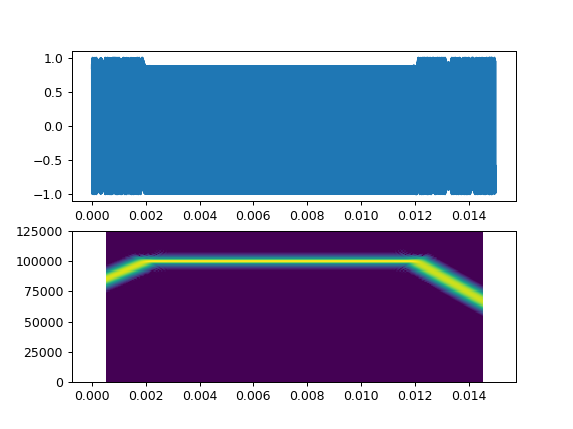

(0, 125000)

In [4]:
call_parameters = {'cf':(100000, 0.01),
                    'upfm':(80000, 0.002),
                    'downfm':(60000, 0.003),
                    }

fs = 500*10**3 # 500kHz sampling rate
synthetic_call, freq_profile = make_cffm_call(call_parameters, fs)

# plot
wavef, spec = visualise_call(synthetic_call, fs, fft_size=512)
spec.set_ylim(0,125000)


### Test parameter space :

Let us now test the performance of the package with audio clips containing only a single call, with no noise or any silent background. This test run will quantify the call-part segmentation (CF-FM).

In [5]:
cf_durations = [0.005, 0.010, 0.02, 0.04, 0.080]
cf_peakfreq = [40000, 60000, 90000]
fm_durations = [0.001, 0.002, 0.003]
fm_bw = [5000, 10000, 20000]

In [6]:
all_combinations = np.array(np.meshgrid(cf_peakfreq, cf_durations,
                                        fm_bw,fm_durations,
                                        np.flip(fm_bw),np.flip(fm_durations)))
all_params = all_combinations.flatten().reshape(6,-1).T

col_names = ['cf_peak_frequency', 'cf_duration',
             'upfm_bw', 'upfm_duration',
             'downfm_bw', 'downfm_duration']

parameter_space = pd.DataFrame(all_params, columns=col_names)
parameter_space['upfm_terminal_frequency'] = parameter_space['cf_peak_frequency'] - parameter_space['upfm_bw']
parameter_space['downfm_terminal_frequency'] = parameter_space['cf_peak_frequency'] - parameter_space['downfm_bw']

In [7]:
parameter_space

,cf_peak_frequency,cf_duration,upfm_bw,upfm_duration,downfm_bw,downfm_duration,upfm_terminal_frequency,downfm_terminal_frequency
0,40000.0,0.005,5000.0,0.001,20000.0,0.003,35000.0,20000.0
1,40000.0,0.005,5000.0,0.001,20000.0,0.002,35000.0,20000.0
2,40000.0,0.005,5000.0,0.001,20000.0,0.001,35000.0,20000.0
3,40000.0,0.005,5000.0,0.001,10000.0,0.003,35000.0,30000.0
4,40000.0,0.005,5000.0,0.001,10000.0,0.002,35000.0,30000.0
...,...,...,...,...,...,...,...,...
1210,90000.0,0.080,20000.0,0.003,10000.0,0.002,70000.0,80000.0
1211,90000.0,0.080,20000.0,0.003,10000.0,0.001,70000.0,80000.0
1212,90000.0,0.080,20000.0,0.003,5000.0,0.003,70000.0,85000.0
1213,90000.0,0.080,20000.0,0.003,5000.0,0.002,70000.0,85000.0


In [8]:
parameter_columns = ['cf_peak_frequency', 'cf_duration',
                     'upfm_terminal_frequency', 'upfm_duration',
                     'downfm_terminal_frequency', 'downfm_duration']

In [9]:
all_calls = {}
for row_number, parameters in tqdm(parameter_space.iterrows(),
                                   total=parameter_space.shape[0]):

    cf_peak, cf_durn, upfm_terminal, upfm_durn, downfm_terminal, downfm_durn = parameters[parameter_columns]
    call_parameters = {'cf':(cf_peak, cf_durn),
                        'upfm':(upfm_terminal, upfm_durn),
                        'downfm':(downfm_terminal, downfm_durn),
                        }

    fs = 500*10**3 # 500kHz sampling rate
    synthetic_call, _ = make_cffm_call(call_parameters, fs)
    synthetic_call *= signal.tukey(synthetic_call.size, 0.01)
    all_calls[row_number] = synthetic_call


100%|█████████████████████████████████████| 1215/1215 [00:05<00:00, 210.73it/s]


In [10]:
parameter_space.shape

(1215, 8)

In [11]:
freq_resolution_columns = ['cf_peakfreq_resolution', 'downfm_terminalfreq_resolution',
                          'upfm_terminalfreq_resolution']

In [12]:
accuracy = parameter_space.copy()

In [13]:
for call_number in trange(parameter_space.shape[0]):
    output = ui.segment_and_measure_call(all_calls[call_number], fs,
                                         peak_percentage=0.995)
    seg_output, call_parts, measurements, backg_output = output
    this_call_msmts = pd.DataFrame(measurements, index=[call_number])
    measurement_accuracy =  this_call_msmts.loc[call_number,parameter_columns]/parameter_space.loc[call_number,parameter_columns]
    accuracy.loc[call_number,parameter_columns] = measurement_accuracy


100%|██████████████████████████████████████| 1215/1215 [22:14<00:00,  1.10s/it]


In [14]:
call_number

1214

In [15]:
this_call_msmts

,call_duration,call_energy,call_rms,peak_frequency,peak_frequency_resolution,cf_start,cf_end,cf_duration,cf_energy,cf_rms,...,upfm_start,upfm_end,downfm_duration,downfm_energy,downfm_rms,downfm_terminal_frequency,downfm_terminalfreq_resolution,downfm_start,downfm_end,terminal_frequency_threshold
1214,0.084,20868.253104,0.704885,90000.0,23.80839,0.002816,0.083206,0.080392,20098.027646,0.707107,...,0.0,0.002814,0.000792,132.36923,0.578157,85858.585859,1262.626263,0.083208,0.083998,-10


In [16]:
accuracy

,cf_peak_frequency,cf_duration,upfm_bw,upfm_duration,downfm_bw,downfm_duration,upfm_terminal_frequency,downfm_terminal_frequency
0,0.995746,1.03440,5000.0,0.906000,20000.0,0.974000,1.009145,0.992471
1,0.997470,1.02760,5000.0,0.916000,20000.0,0.973000,0.998129,0.976362
2,1.000190,1.05480,5000.0,0.816000,20000.0,0.910000,0.980392,0.934066
3,0.998081,1.04200,5000.0,0.906000,10000.0,0.961333,1.009145,0.982432
4,1.001742,1.03320,5000.0,0.916000,10000.0,0.959000,0.998129,0.990615
...,...,...,...,...,...,...,...,...
1210,1.000100,1.00490,20000.0,0.938667,10000.0,0.896000,1.014610,1.011440
1211,0.999878,1.00415,20000.0,0.938667,10000.0,0.852000,1.014610,1.026995
1212,0.999884,1.00720,20000.0,0.938667,5000.0,0.869333,1.014610,1.001444
1213,0.999873,1.00610,20000.0,0.938667,5000.0,0.848000,1.014610,1.005827


In [17]:
parameter_columns

['cf_peak_frequency',
 'cf_duration',
 'upfm_terminal_frequency',
 'upfm_duration',
 'downfm_terminal_frequency',
 'downfm_duration']

In [18]:
all_accuracy_to_plot = [ accuracy[col] for col in parameter_columns]
column_names = ['CF \n peak', 'CF \n duration', 'UpFM \n terminal', 'UpFM \n duration',
               'DownFM \n terminal', 'DownFM \n duration']

<IPython.core.display.Javascript object>


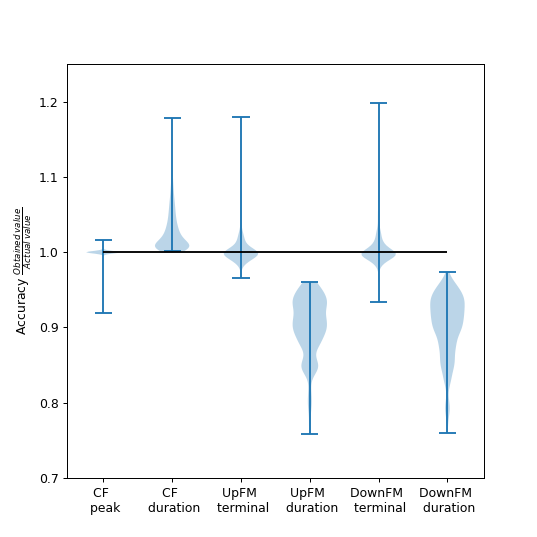

In [19]:
plt.figure(figsize=(6,6))
a = plt.violinplot(all_accuracy_to_plot, positions=range(1,7));
plt.xticks(range(1,7), column_names, fontsize=10);
plt.yticks(np.arange(0.7,1.35,0.1))
plt.ylim(0.7, 1.25) ;plt.hlines(1, 1,6);
plt.ylabel('Accuracy $\\frac{Obtained\:value}{Actual \:value}$', fontsize=10)
plt.savefig('package_accuracy_test.pdf')